<a href="https://colab.research.google.com/github/Abhishek92kumar/LJMU/blob/main/Extract_Tables_from_Image_Document_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U layoutparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-x931dfla/detectron2_550804c5f6d5416aa06aaf8db526cb45
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-x931dfla/detectron2_550804c5f6d5416aa06aaf8db526cb45
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done


In [3]:
!pip install layoutparser[ocr]     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


In [5]:
%cd layout-parser/

/content/layout-parser


In [6]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/paper-image.jpg")
image = image[..., ::-1] 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


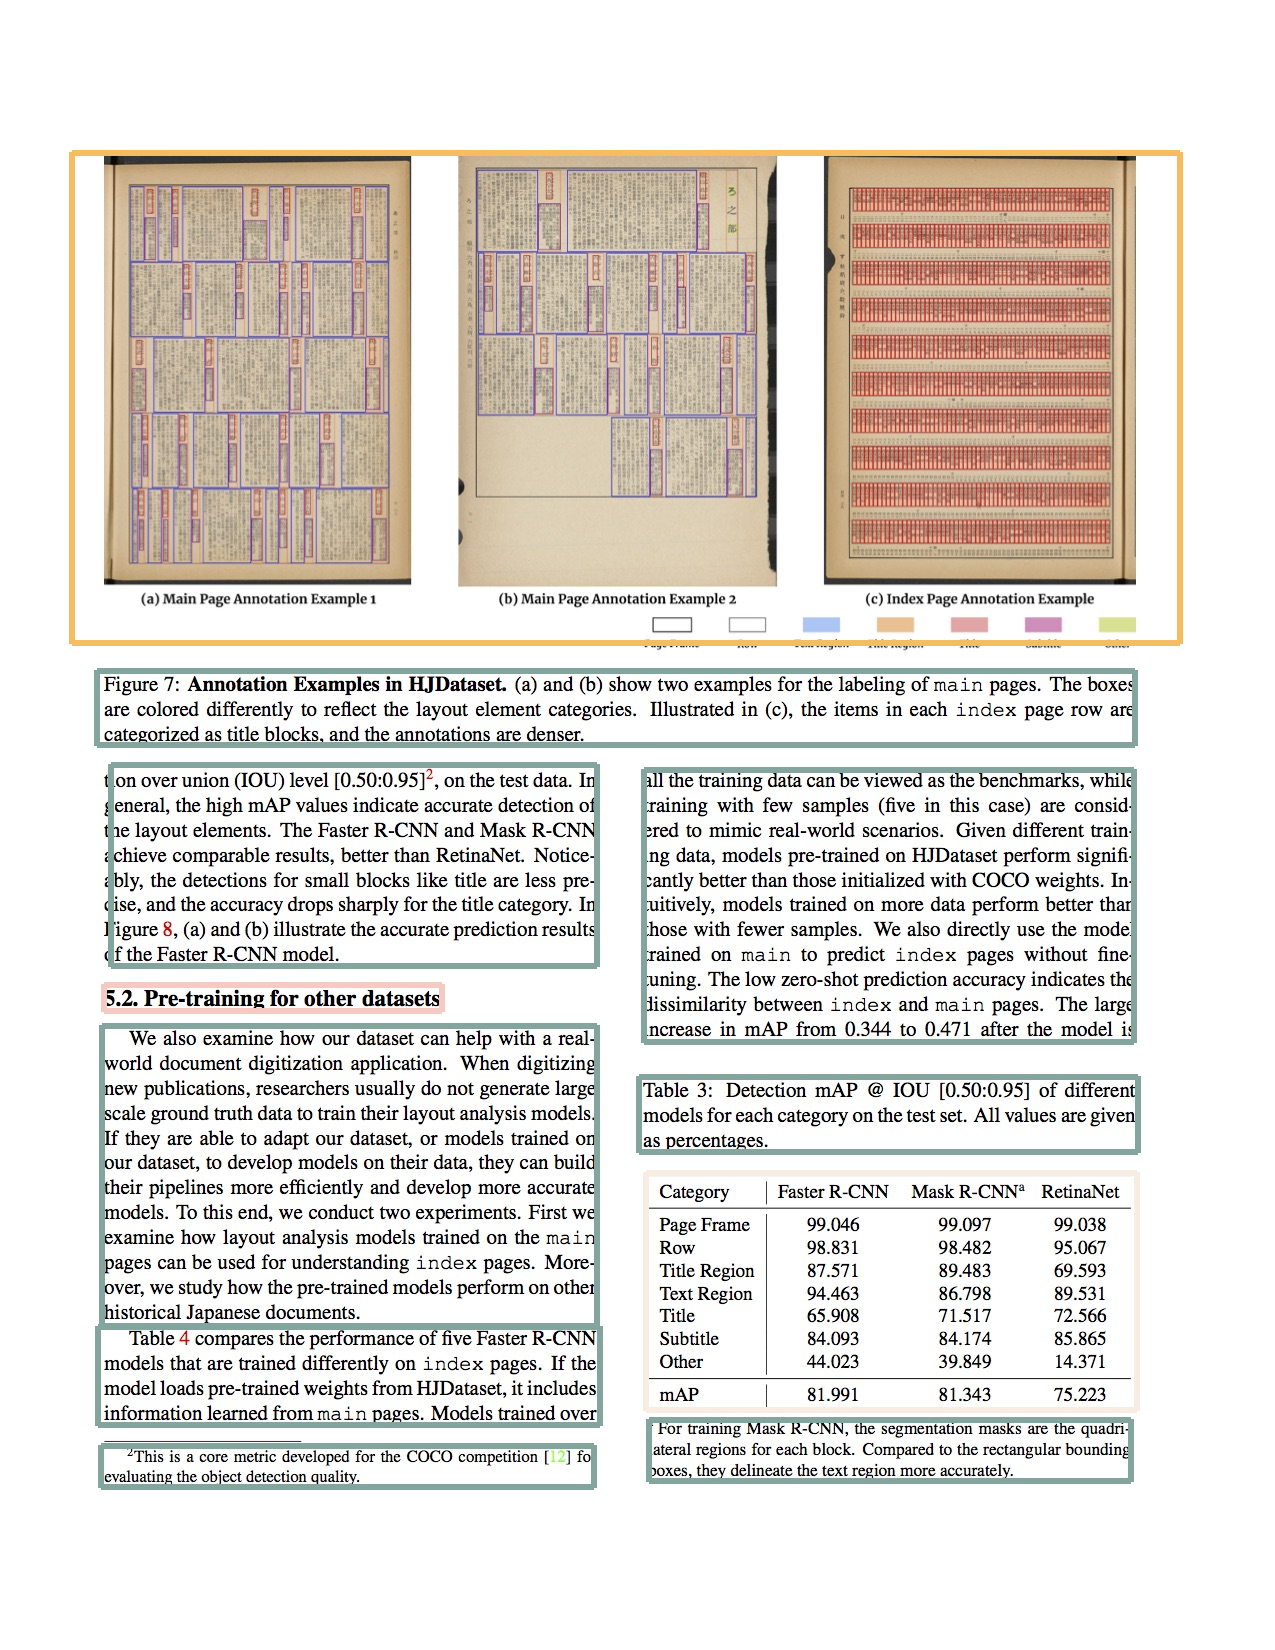

In [7]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [8]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=646.430908203125, y_1=1172.260498046875, x_2=1136.59619140625, y_2=1410.0213623046875), text=None, id=None, type=Table, parent=None, next=None, score=0.9608720541000366)], page_data={})

In [9]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [10]:
figure_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=72.3290023803711, y_1=152.1854705810547, x_2=1179.6292724609375, y_2=643.6030883789062), text=None, id=None, type=Figure, parent=None, next=None, score=0.9979682564735413)], page_data={})

In [11]:

text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [12]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

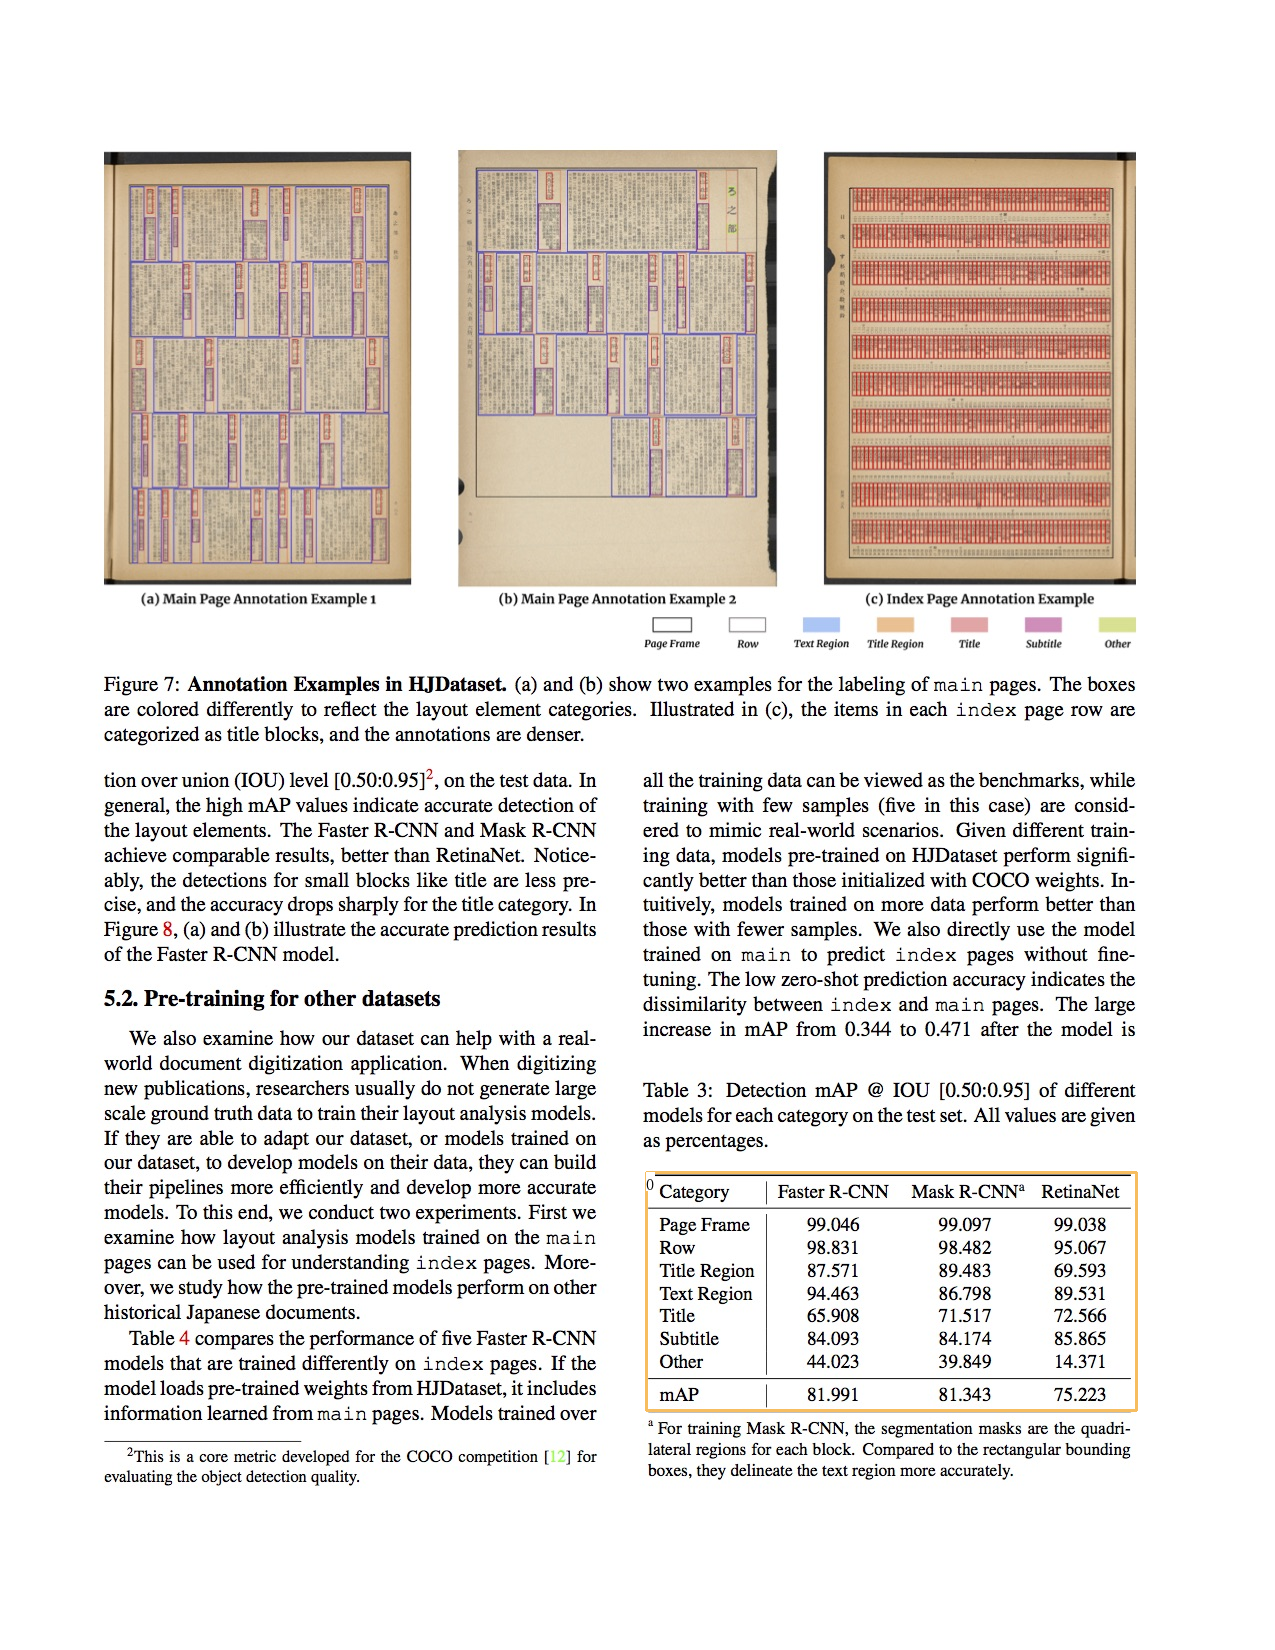

In [13]:

lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [14]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [15]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [16]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [17]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Category | FasterR-CNN Mask R-CNN* RetinaNet

Page Frame 99.046 99.097 99.038
Row 98.831 98.482 95.067
Title Region 87.571 89.483 69.593
Text Region 94.463 86.798 89.531
Title 65.908 TES17 72.566
Subtitle 84.093 84.174 85.865
Other 44.023 39.849 14.371

mAP | 81.991 81.343 75.223

---


In [18]:
text_blocks.get_texts()

['Category | FasterR-CNN Mask R-CNN* RetinaNet\n\nPage Frame 99.046 99.097 99.038\nRow 98.831 98.482 95.067\nTitle Region 87.571 89.483 69.593\nText Region 94.463 86.798 89.531\nTitle 65.908 TES17 72.566\nSubtitle 84.093 84.174 85.865\nOther 44.023 39.849 14.371\n\nmAP | 81.991 81.343 75.223\n\x0c']

In [19]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=646.430908203125, y_1=1172.260498046875, x_2=1136.59619140625, y_2=1410.0213623046875), text=Category | FasterR-CNN Mask R-CNN* RetinaNet

Page Frame 99.046 99.097 99.038
Row 98.831 98.482 95.067
Title Region 87.571 89.483 69.593
Text Region 94.463 86.798 89.531
Title 65.908 TES17 72.566
Subtitle 84.093 84.174 85.865
Other 44.023 39.849 14.371

mAP | 81.991 81.343 75.223
, id=0, type=Table, parent=None, next=None, score=0.9608720541000366)


In [20]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-22 17:59:07.055162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 17:59:08.176821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-22 17:59:09.447569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 17:59:09.448011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node rea

In [22]:
!pip install click==7.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import spacy
nlp = spacy.load("en_core_web_trf")


In [24]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [25]:
".".join(sentence)  

'Category | FasterR-CNN Mask R-CNN* RetinaNet\n\nPage Frame 99.046 99.097 99.038\nRow 98.831 98.482 95.067\nTitle Region 87.571 89.483 69.593\nText Region 94.463 86.798 89.531\nTitle 65.908 TES17 72.566\nSubtitle 84.093 84.174 85.865\nOther 44.023 39.849 14.371\n\nmAP | 81.991 81.343 75.223\n\x0c'

In [26]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

99.046 CARDINAL
98.831 CARDINAL
87.571 CARDINAL
94.463 86.798 CARDINAL
65.908 CARDINAL
84.093 CARDINAL
